In [31]:
import pandas as pd
import numpy as np
from database import engine
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import subprocess
from ingredient_map import create_ingredient_map
import quant_preprocess as qp

import os


INPUT_PATH = os.path.join("..\\data", "ingredient_prices_clean.csv")
TABLE_DIR = "tables"
FIGURE_DIR = "figures"
ABV_DATA = os.path.join("data", "ABV_data.csv")



liquors = ["brandy","gin","tequila","vodka","whiskey","flavored rum","flavored vodka","cognac","bourbon","rum","scotch","grain alcohol"]

In [32]:
def create_dummies():
    """"Creates dummy variables for ingredients"""
    
    df = qp.query_and_preprocess_data()
    headers = df.columns[1:]
    d = {'strdrink': df['strdrink'].values.tolist()}
    for e in range(0, len(headers)):
        d[headers[e]] = (df[str(headers[e])] > 0).astype(int).values.tolist()
    return pd.DataFrame.from_dict(d)

In [33]:
def price_and_abv_preprocessed():
    """Function combines the cocktails, prices, and abv data to prepare it for analysis"""

    ABV_DATA = os.path.join("..\\data", "ABV_data.csv")
    df = qp.query_and_reshape_long()
    recoded = qp.recode_long_data(df)

    ingredient_prices = qp.query_ingredient_prices()
    abv_data = pd.read_csv(ABV_DATA)

    combined = (
        recoded
        .merge(ingredient_prices, how = "left", on = "ingredient")
        .merge(abv_data, how = "left", on = "ingredient")
        .fillna(0)
        .assign(
            ounces_alcohol = lambda df_: df_["amount"] * df_["abv_percent"])
        .groupby("strdrink")
        .agg({
            "ingredient":"count",
            "amount": "sum",
            "price":"sum",
            "ounces_alcohol": "sum"})
        .assign(
            weighted_abv = lambda df_: df_["ounces_alcohol"] / df_["amount"],
            oz_alc_per_dollar = lambda df_: df_["ounces_alcohol"] / df_["price"])
        .rename(columns  = {
            "ingredient" : "num_ingredients",
            "amount": "total_ounces",
            "price" : "cost"
            })
        )

    return combined


In [34]:
def ols_model():
    
    data = drop_all_zero_dummies()
    display(data)
    df = price_and_abv_preprocessed()
    display(df)
    ols_model = data.merge(df,how="left",on="strdrink")

    return ols_model

In [35]:
def summmary_of_oz():
    """"Creates summary table for ingredients in ounces"""
    
    df = qp.query_and_preprocess_data()
    df = df.describe().transpose().sort_values('mean',
                                ascending = False).head(10)
    df = df[["mean"]]
    return df

In [36]:
def summary_of_usage():
    
    os.makedirs(TABLE_DIR, exist_ok=True)
    
    filename = os.path.join(TABLE_DIR,'usage.tex')
    pdffile = os.path.join(TABLE_DIR, 'usage.pdf')
    outname = os.path.join(TABLE_DIR, 'usage.png')
    
    dum_df = create_dummies()
    data = dum_df.describe().transpose().sort_values('mean', 
                                    ascending=False).head(10)
    data = data[["mean"]]
    data = data.rename(columns={"mean":"Proportion of Drinks"})
    data.index.name = "Ingredient"
    
    template = r'''\documentclass[preview]{{standalone}}
    \usepackage{{booktabs}}
    \begin{{document}}
    {}
    \end{{document}}
    '''
    with open(filename, 'wt') as f:
        f.write(template.format(data.to_latex()))
    subprocess.call(['pdflatex', filename])
    subprocess.call(['convert', '-density', '300', pdffile, '-quality', '90', outname])

    

In [37]:
summary_of_usage()

In [40]:
def get_amount_table():
    
    
    df = qp.query_data()
    ingred_cols = qp.get_cols_list(df, "stringredient")
    measure_cols = qp.get_cols_list(df, "strmeasure")
    df[ingred_cols] = qp.cols_to_lower(df, ingred_cols)
    ingredient_long = qp.shape_data_long(
            df, ingred_cols, "stringredient", "", "ingredient"
        )
    measure_long = qp.shape_data_long(df, measure_cols, "strmeasure", "_clean", "amount")
    combined_long = qp.merge_long(ingredient_long, measure_long)
    ingredient_dict = qp.create_ingredient_map()
    recoded_long = qp.recode_ingredients(combined_long, ingredient_dict)
    combined_wide = qp.pivot_wide(recoded_long)
    return combined_wide


In [41]:
def drop_big_drinks():

    
    df = get_amount_table()
    df = df.set_index("strdrink")
    df = df.transpose()
    for d in df:
        if (df.sum(axis=0)[d] < 2.5) or (df.sum(axis=0)[d] > 15):
            df = df.drop(d,axis=1)
    return df.columns.values.tolist()
    


In [9]:
def number_of_ingredients():
    
    ingreds = []
    drinks = drop_big_drinks()
    data = create_dummies()
    data = data.set_index("strdrink")
    data = data.transpose()[drinks]
    return data.sum(axis=0).tolist()

    

In [10]:
def prices_list():
    
    df_prices = pd.read_csv(INPUT_PATH, header=None)
    df_prices = df_prices.sort_values(0, ascending=True)
    df_prices = df_prices.transpose()
    prices = df_prices.loc[1].values.tolist()
    return prices

In [11]:
def combine_prices_ingredients():
    
    ingredients = get_amount_table()
    ingredients = ingredients.transpose()
    ingredients =  ingredients.drop(labels="strdrink",axis=0)
    prices = prices_list()
    ingredients["prices"] = prices
    return ingredients

In [12]:
def get_ingredient_cost():
    df = get_amount_table()
    drinks = df["strdrink"].values.tolist()
    df = combine_prices_ingredients()
    for i in range(0,627):
        df[i] = df[i]*df["prices"]
    df= df.transpose()
    df = df.drop(labels = "prices", axis = 0)
    df["strdrink"] = drinks
    df = df.transpose()
    return df

In [13]:
def drop_all_zero_dummies():

    liquors = ["brandy","gin","tequila","vodka","whiskey","flavored rum","flavored vodka","cognac","bourbon","rum","scotch","grain alcohol"]
    small_drinks = drop_big_drinks()
    data = create_dummies().set_index("strdrink").transpose()
    data = data[small_drinks].transpose()
    data = data[liquors].replace(0, np.nan)
    data = data.dropna(how='all', axis=0)
    data = data.replace(np.nan, 0)

    return data

In [47]:
def most_popular_liquor_table():
    
    
    os.makedirs(TABLE_DIR, exist_ok=True)

    
    filename = os.path.join(TABLE_DIR, 'pop_liquor.tex')
    pdffile = os.path.join(TABLE_DIR,'pop_liquor.pdf')
    outname = os.path.join(TABLE_DIR,'pop_liquor.png')
    df = drop_all_zero_dummies()
    df = df.describe().transpose().sort_values('mean', 
                                        ascending=False).head(15)
    df = df[["mean"]]
    df = df.rename(columns={"mean":"Proportion of Drinks"})
    df.index.name = "Liquor"
    
    template = r'''\documentclass[preview]{{standalone}}
    \usepackage{{booktabs}}
    \begin{{document}}
    {}
    \end{{document}}
    '''
    with open(filename, 'wt') as f:
        f.write(template.format(df.to_latex()))
    subprocess.call(['pdflatex', filename])
    subprocess.call(['convert', '-density', '300', pdffile, '-quality', '90', outname])

In [48]:
most_popular_liquor_table()

In [15]:
def ounces_of_alc():
    
    liquor = pd.read_csv('https://raw.githubusercontent.com/ElliottMetzler/the-manhattan-project/quant/data/ABV_list.csv')
    liquor.columns = ["ingredient", "abv"]
    l = liquor['ingredient'].values.tolist()
    small = drop_big_drinks()
    data = get_amount_table()
    data = data.set_index("strdrink")
    drinks = data.index.values.tolist()
    data = data[l].transpose()
    data = data[small]
    data = pd.merge(data,liquor,how="left",on="ingredient")
    data = data.drop("ingredient",axis=1)
    for d in data:
        data[d] = data[d].multiply(data["abv"])
    data["ingredient"] = l
    data = data.drop("abv",axis=1)
    data = data.sum(axis=0)
    data = pd.DataFrame(data)
    data = data.transpose().drop("ingredient", axis=1)
    return data



In [16]:
def model():
    """"Creates a dataframe that contains our dependent and independent variables for the OLS regression."""
    
    co = get_cost_per_alc_ounce().transpose()
    liquors = ["brandy","gin","tequila","vodka","whiskey","flavored rum","flavored vodka","cognac","bourbon","rum","scotch","grain alcohol"]
    number = number_of_ingredients()
    data = get_ingredient_cost()
    amounts = get_amount_table()
    data.columns = data.loc['strdrink']
    drinks = data.columns.values.tolist()
    data = data.drop("strdrink", axis=0)
    df_cost = data.transpose()
    cost = df_cost.sum(axis=1).values.tolist()
    amounts = amounts.sum(axis=1).values.tolist()
    d = {
        "strdrink": drinks,
        "cost": cost,
        "total oz": amounts
    }
    drinks = drop_big_drinks()
    co["drinks"] = drinks
    df = pd.DataFrame(d).set_index("strdrink").transpose()
    df = df[drinks].transpose()
    df["number of ingredients"] = number
    dummies = create_dummies().set_index("strdrink")
    dummies = dummies[liquors]
    dummies = dummies.replace(0, np.nan)
    dummies = dummies.dropna(how='all', axis=0)
    dummies = dummies.replace(np.nan, 0)
    model = dummies.merge(df, how="inner",on="strdrink")
    co = co.rename(columns={"drinks":"strdrink",0:"abv"})
    model = model.merge(co,how="inner",on='strdrink')
    model["alc per dollar"] = model["abv"]/model["cost"]
    model["abv"] = pd.to_numeric(model["abv"])
    model["alc per dollar"] = pd.to_numeric(model["alc per dollar"])
    
    
    return model


In [17]:
def heat_price_corr_heat():
    model = ols_model()
    
    corr = model.corr()
    corr_heat = sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns,cmap="RdBu")

    return corr_heat

In [18]:
model = ols_model()
    
model.corr()

,brandy,gin,tequila,vodka,whiskey,flavored rum,flavored vodka,cognac,bourbon,rum,scotch,grain alcohol
strdrink,,,,,,,,,,,,
1-900-FUK-MEUP,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
155 Belmont,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3-Mile Long Island Iced Tea,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
410 Gone,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
50/50,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
Winter Rita,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Yellow Bird,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Zipperhead,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,num_ingredients,total_ounces,cost,ounces_alcohol,weighted_abv,oz_alc_per_dollar
strdrink,,,,,,
1-900-FUK-MEUP,8,2.50,5.102104,0.4250,0.170000,0.083299
110 in the shade,2,17.50,0.759687,1.4000,0.080000,1.842863
151 Florida Bushwacker,8,15.50,4.623516,1.0500,0.067742,0.227100
155 Belmont,4,7.50,1.494557,2.4000,0.320000,1.605827
24k nightmare,4,2.00,2.195000,0.3750,0.187500,0.170843
...,...,...,...,...,...,...
Zizi Coin-coin,4,6.87,1.450712,0.2535,0.036900,0.174742
Zoksel,7,6.50,1.568750,0.2000,0.030769,0.127490
Zombie,7,4.51,5.020212,1.6680,0.369845,0.332257


,brandy,gin,tequila,vodka,whiskey,flavored rum,flavored vodka,cognac,bourbon,rum,scotch,grain alcohol,num_ingredients,total_ounces,cost,ounces_alcohol,weighted_abv,oz_alc_per_dollar
brandy,1.000000,-0.038156,-0.104257,-0.140772,-0.047591,-0.027864,-0.044414,-0.044255,0.012107,-0.091861,-0.019248,-0.019674,-0.036455,-0.038364,-0.084889,0.021778,0.020783,0.038124
gin,-0.038156,1.000000,-0.080057,-0.157972,-0.170493,-0.047887,-0.147208,0.033335,-0.133756,-0.269337,-0.119083,-0.033811,0.173884,-0.084456,0.284585,0.212992,0.249302,-0.105195
tequila,-0.104257,-0.080057,1.000000,0.014677,-0.090094,-0.022272,-0.068465,-0.035373,-0.062209,0.001932,-0.055385,-0.015725,0.150585,0.074561,0.037000,0.112160,0.018550,0.046532
vodka,-0.140772,-0.157972,0.014677,1.000000,-0.109861,-0.039785,-0.122302,-0.063188,-0.075858,-0.129899,-0.098936,-0.028090,0.012506,0.152068,-0.173225,-0.063112,-0.180747,0.100606
whiskey,-0.047591,-0.170493,-0.090094,-0.109861,1.000000,-0.024079,-0.074020,-0.038243,-0.016739,-0.164474,-0.059878,-0.017001,-0.014763,-0.054574,-0.006473,-0.055212,-0.015161,-0.096360
flavored rum,-0.027864,-0.047887,-0.022272,-0.039785,-0.024079,1.000000,-0.018298,-0.009454,-0.016626,-0.046477,-0.014802,-0.004203,-0.130457,-0.074016,-0.110057,-0.063485,0.000046,0.074673
flavored vodka,-0.044414,-0.147208,-0.068465,-0.122302,-0.074020,-0.018298,1.000000,-0.029062,-0.051110,-0.083256,-0.045503,-0.012920,-0.007281,-0.030843,-0.111223,-0.097062,-0.091346,0.040733
cognac,-0.044255,0.033335,-0.035373,-0.063188,-0.038243,-0.009454,-0.029062,1.000000,-0.026406,-0.018372,-0.023510,-0.006675,0.012513,-0.028872,0.189563,0.025525,0.026916,-0.078191
bourbon,0.012107,-0.133756,-0.062209,-0.075858,-0.016739,-0.016626,-0.051110,-0.026406,1.000000,-0.064814,-0.041345,-0.011739,0.032740,-0.048972,0.096906,0.018407,0.092040,-0.076636
rum,-0.091861,-0.269337,0.001932,-0.129899,-0.164474,-0.046477,-0.083256,-0.018372,-0.064814,1.000000,-0.079407,-0.032816,0.201537,0.079977,-0.023519,0.035175,-0.097397,0.033877


,brandy,gin,tequila,vodka,whiskey,flavored rum,flavored vodka,cognac,bourbon,rum,scotch,grain alcohol
strdrink,,,,,,,,,,,,
1-900-FUK-MEUP,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
155 Belmont,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3-Mile Long Island Iced Tea,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
410 Gone,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
50/50,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
Winter Rita,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Yellow Bird,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Zipperhead,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,num_ingredients,total_ounces,cost,ounces_alcohol,weighted_abv,oz_alc_per_dollar
strdrink,,,,,,
1-900-FUK-MEUP,8,2.50,5.102104,0.4250,0.170000,0.083299
110 in the shade,2,17.50,0.759687,1.4000,0.080000,1.842863
151 Florida Bushwacker,8,15.50,4.623516,1.0500,0.067742,0.227100
155 Belmont,4,7.50,1.494557,2.4000,0.320000,1.605827
24k nightmare,4,2.00,2.195000,0.3750,0.187500,0.170843
...,...,...,...,...,...,...
Zizi Coin-coin,4,6.87,1.450712,0.2535,0.036900,0.174742
Zoksel,7,6.50,1.568750,0.2000,0.030769,0.127490
Zombie,7,4.51,5.020212,1.6680,0.369845,0.332257


<AxesSubplot:>

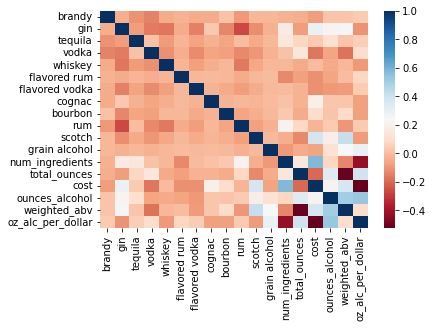

In [19]:
heat_price_corr_heat()

In [21]:
def ols_price_on_liquor():
    """Perform OLS regression of pure alchohol per dollar on total ounces, number of ingredient"""

    df = ols_model()
    covars = ["total_ounces","ounces_alcohol","num_ingredients","brandy","gin","tequila","vodka","whiskey","flavored rum","flavored vodka","cognac","bourbon","rum","scotch"]
 
    x = df[covars]
    y = df["oz_alc_per_dollar"]


    model = sm.OLS(y.astype(float), sm.add_constant(x.astype(float))).fit()
    model_summary = model.summary()

    fig, ax = plt.subplots(figsize=(12, 7))

    ax.text(
        0.01, 0.05, str(model_summary), {"fontsize": 10}, fontproperties="monospace"
    )
    ax.axis("off")
    plt.tight_layout()



,brandy,gin,tequila,vodka,whiskey,flavored rum,flavored vodka,cognac,bourbon,rum,scotch,grain alcohol
strdrink,,,,,,,,,,,,
1-900-FUK-MEUP,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
155 Belmont,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3-Mile Long Island Iced Tea,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
410 Gone,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
50/50,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
Winter Rita,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Yellow Bird,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Zipperhead,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,num_ingredients,total_ounces,cost,ounces_alcohol,weighted_abv,oz_alc_per_dollar
strdrink,,,,,,
1-900-FUK-MEUP,8,2.50,5.102104,0.4250,0.170000,0.083299
110 in the shade,2,17.50,0.759687,1.4000,0.080000,1.842863
151 Florida Bushwacker,8,15.50,4.623516,1.0500,0.067742,0.227100
155 Belmont,4,7.50,1.494557,2.4000,0.320000,1.605827
24k nightmare,4,2.00,2.195000,0.3750,0.187500,0.170843
...,...,...,...,...,...,...
Zizi Coin-coin,4,6.87,1.450712,0.2535,0.036900,0.174742
Zoksel,7,6.50,1.568750,0.2000,0.030769,0.127490
Zombie,7,4.51,5.020212,1.6680,0.369845,0.332257


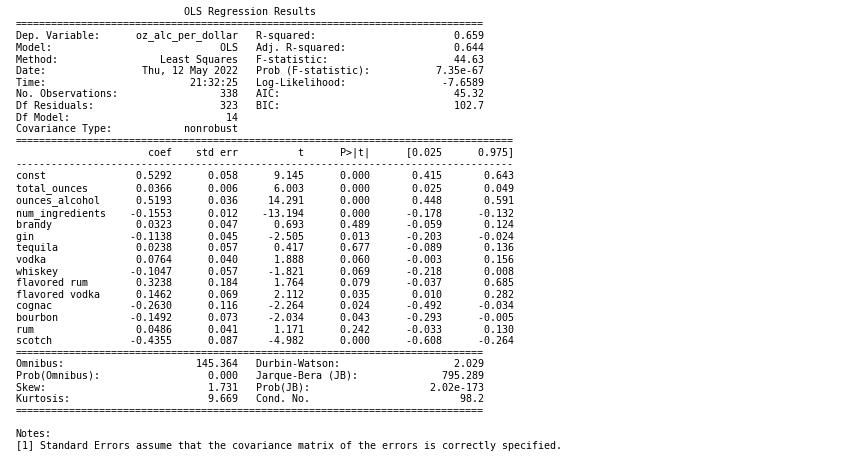

In [22]:
ols_price_on_liquor()

In [51]:
def save_plot(figure_obj, output_directory, output_file_name):
    """Function takes in a figure, the output directory and file name and saves the figure"""
    
    path = os.path.join(output_directory, output_file_name)
    figure_obj.savefig(path)


In [52]:
def check_covar_costs():
    """"Creates dataframe for the cost of covariates in the OLS regression and outputs as a bar graph"""
    
    df_prices = pd.read_csv(INPUT_PATH, header=None)
    df_prices = df_prices.transpose()
    df_prices.columns = df_prices.loc[0]
    df_prices = df_prices.drop(0)
    df_prices = df_prices[["brandy","gin","tequila","vodka","whiskey","flavored rum","flavored vodka","cognac","bourbon","rum","scotch","grain alcohol"]]
    plot = df_prices.plot.bar(figsize=(15,4),title="Summary of Liquor Cost")
    plot = plot.set(xlabel="Type of Liquor",ylabel="Cost Per Ounce")
    
    return plot

In [24]:
if __name__ == "__main__":
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    save_plot(figure_obj, output_directory, output_file_name)
    
    

NameError: name 'OUTPUT_DIR' is not defined